In [4]:
import numpy as np
from einops import rearrange

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import linalg

import os

from baukit import Trace, TraceDict

from llava.model import *
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from utils import *

from transformers import AutoTokenizer
import torch

from PIL import Image
import json
import math
from functools import partial

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
 # HARDCODED FOR LLAVA
num_heads = 40
num_layers = 40

In [9]:
base_dir = '../probing/features_attack/'
features_dir = os.listdir(base_dir)
n_options = 2
features_dir = [os.path.join(base_dir, dir) for dir in features_dir if f'noption_{n_options}' in dir]

head_wise_activations_all = []
for dir in features_dir:
    head_wise_activations = np.load(f"{dir}/head_wise.npy")
    head_wise_activations = rearrange(head_wise_activations, 'b l (h d) -> b l h d', h = num_heads)
    head_wise_activations_all.append(head_wise_activations)
head_wise_activations_all = np.stack(head_wise_activations_all)

In [10]:
def get_head_similarity_dict(head_value_matrix):
    head_sim_dict = {f'l{l}_h{h}': [] for l in range(num_layers) for h in range(num_heads)} 
    # ^ each dict value with be an array of length #n_question
    for q_idx in tqdm(range(head_value_matrix.shape[1])):
        q_head_vals = head_value_matrix[:, q_idx, :, :, :]
        for l in range(num_layers):
            for h in range(num_heads):
                vectors = q_head_vals[:, l, h, :]
                cosine_sim = cosine_similarity(vectors)
                pairwise_sim = cosine_sim[np.triu_indices_from(cosine_sim, k=1)]
                avg_sim = np.mean(pairwise_sim) #taking mean across permutations
                head_sim_dict[f'l{l}_h{h}'].append(avg_sim)
    return head_sim_dict

head_similsrity_dict = get_head_similarity_dict(head_wise_activations_all)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2228/2228 [08:42<00:00,  4.27it/s]


In [16]:
len(head_similsrity_dict['l0_h0'])

2228

mean 0.13077302425166468 0.9999948626966866


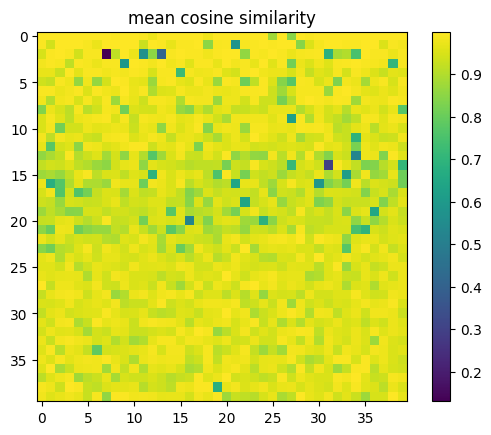

In [19]:
mean_sim_noption = [np.mean(head_similsrity_dict[key]) for key in list(head_similsrity_dict.keys())] #taking mean across questions
l_h_sim_avg = np.array(mean_sim_noption).reshape(num_heads, num_layers) # row = heads | colums = layers
print('mean', np.amin(l_h_sim_avg), np.amax(l_h_sim_avg))
plt.title("mean cosine similarity")
plt.imshow(l_h_sim_avg)
plt.colorbar()

## lets do a little analysis

In [26]:
np.argwhere(l_h_sim_avg<.8).shape

(39, 2)

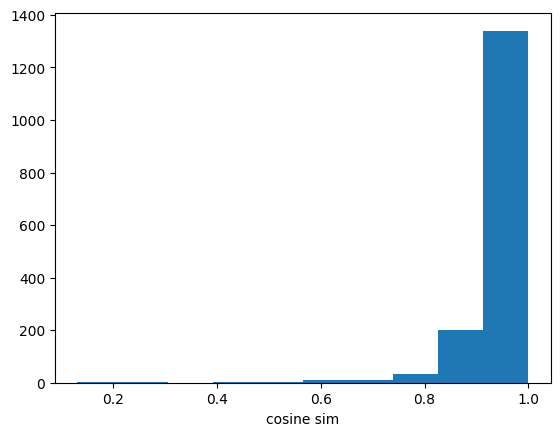

In [25]:
l_h_sim_avg_flattened = l_h_sim_avg.flatten()
counts, bins = np.histogram(l_h_sim_avg_flattened)
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel('cosine sim')
plt.show()

## Ok lets get to the actual scaling/editing

In [227]:
cosine_thr = 0.9
num_to_intervene = len(np.argwhere(l_h_sim_avg_flattened < cosine_thr))
scaling_power = .5

def flattened_idx_to_layer_head(flattened_idx, num_heads):
    return flattened_idx // num_heads, flattened_idx % num_heads

def layer_head_to_flattened_idx(layer, head, num_heads):
    return layer * num_heads + head
    
def get_top_heads(cosine_mtrx, num_to_intervene):
    top_cosine = np.argsort(cosine_mtrx.reshape(num_heads*num_layers))[:num_to_intervene]
    top_heads = [flattened_idx_to_layer_head(idx, num_heads) for idx in top_cosine]
    return top_heads

In [228]:
def get_interventions_dict(top_heads, cosine_matrix):
    interventions = {}
    for layer, head in top_heads: 
        interventions[f"model.layers.{layer}.self_attn.o_proj"] = []
    for layer, head in top_heads:
        interventions[f"model.layers.{layer}.self_attn.o_proj"].append((head, cosine_matrix[layer, head]))
    for layer, head in top_heads: 
        interventions[f"model.layers.{layer}.self_attn.o_proj"] = sorted(interventions[f"model.layers.{layer}.self_attn.o_proj"], key = lambda x: x[0])
    return interventions

In [229]:
# same default alpha as ITI
def lt_scale(head_output, layer_name, start_edit_location='lt'): 
    head_output = rearrange(head_output, 'b s (h d) -> b s h d', h=num_heads)
    for head, cos in interventions[layer_name]:
        if start_edit_location == 'lt': 
            head_output[:, -1, head, :] = head_output[:, -1, head, :]
        else: 
            head_output[:, start_edit_location:, head, :] = head_output[:, -1, head, :] * cos * scaling_power
    head_output = rearrange(head_output, 'b s h d -> b s (h d)')
    return head_output

In [230]:
def get_answer_with_intervention(model, tokenizer, prompt, images, stopping_criteria, interventions={}, intervention_fn=None):
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
    # --- intervention code --- #
    def id(head_output, layer_name): 
        return head_output
    if interventions == {}: 
        intervene = id
        layers_to_intervene = []
    else: 
        print("INTERVENING!")
        intervene = partial(intervention_fn, start_edit_location='lt')
        layers_to_intervene = list(interventions.keys())
    # --- intervention code --- #
    sequences = []
    with torch.no_grad():
        # for idx, input_ids in enumerate(tqdm(tokens)):
        max_len = input_ids.shape[-1] + 50

        # --- intervention code --- #

        with TraceDict(model, layers_to_intervene, edit_output=intervene) as ret: 
            # input_ids = input_ids.cuda()
            
            model_output = model.generate(input_ids, 
                                          images=images, 
                                          do_sample=True,
                                          max_new_tokens=1024,
                                          stopping_criteria=stopping_criteria,
                                         )
            model_gen_tokens = model_output['sequences'][:, input_ids.shape[-1]:]
        # print(model_gen_tokens[0])
        model_gen_str = tokenizer.decode(model_gen_tokens[0], skip_special_tokens=True)
        model_gen_str = model_gen_str.strip()

        try: 
            # remove everything after 'Q:'
            model_gen_str = model_gen_str.split("Q:")[0].strip()
            # keep everything after A: 
            model_gen_str = model_gen_str.split("A:")[1].strip()
        except: 
            pass
            # --- intervention code --- #

    if device:
        torch.cuda.empty_cache()
    return model_gen_str

In [231]:
top_heads = get_top_heads(l_h_sim_avg, num_to_intervene)

### Lets compare original model answer and edited answer

In [232]:
def split_list(lst, n):
    """Split a list into n (roughly) equal-sized chunks"""
    chunk_size = math.ceil(len(lst) / n)  # integer division
    return [lst[i:i+chunk_size] for i in range(0, len(lst), chunk_size)]

def get_chunk(lst, n, k):
    chunks = split_list(lst, n)
    return chunks[k]

In [233]:
model_path = 'liuhaotian/llava-v1.5-13b'
conv_mode = 'llava_v1'
device = 0

In [234]:
def get_models():
    kwargs = {"device_map": "auto"}

    tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
    model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, return_dict_in_generate=True, **kwargs)
    model.to(torch.float16)

    vision_tower = model.get_vision_tower()
    if not vision_tower.is_loaded:
        vision_tower.load_model()
    vision_tower.to(device=device, dtype=torch.float16)
    image_processor = vision_tower.image_processor 
    return tokenizer, model, image_processor
tokenizer, model, image_processor = get_models()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [338]:
question_file = '/home/ubuntu/ScienceQA/data/scienceqa/stratified_attack/attack_choice_1_noption_3_test.json'
image_folder = '/home/ubuntu/ScienceQA/test'

In [339]:
questions = json.load(open(question_file, "r"))
questions = get_chunk(questions, 1, 0)
random_question = np.random.choice(questions)

In [340]:
random_question

{'id': '4520',
 'conversations': [{'from': 'human',
   'value': 'Compare the motion of three ducks. Which duck was moving at the highest speed?\nContext: N/A\nOptions: (A) a duck that moved 175miles west in 5hours (B) a duck that moved 260miles north in 5hours (C) a duck that moved 220miles east in 5hours'},
  {'from': 'gpt',
   'value': "An object's speed tells you how fast the object is moving. Speed depends on both distance and time.\nDistance tells you how far the object has moved. One unit used to measure distance is the mile.\nTime tells you how long the object has spent moving. One unit used to measure time is the hour.\nThink about objects moving for the same amount of time. The object that is moving the fastest will go the farthest distance in that time. It is moving at the highest speed. Look at the distance each duck moved and the time it took to move that distance. The direction each duck moved does not affect its speed.\nNotice that each duck moved for 5 hours. The duck th

In [341]:
options = ["A", "B", "C", "D", "E"]
question = random_question['conversations'][0]
qs = question['value'].replace('<image>', '').strip()
answer_idx = random_question['new_gt']

answer = f"The answer is ({options[answer_idx]})"
print("Ground truth")
print("Question: ", qs)
print("Answer: ", answer)

Ground truth
Question:  Compare the motion of three ducks. Which duck was moving at the highest speed?
Context: N/A
Options: (A) a duck that moved 175miles west in 5hours (B) a duck that moved 260miles north in 5hours (C) a duck that moved 220miles east in 5hours
Answer:  The answer is (B)


In [342]:
cur_prompt = qs
if 'image' in random_question:
    image_file = random_question["image"]
    image = Image.open(os.path.join(image_folder, image_file))
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'][0]
    images = image_tensor.unsqueeze(0).half().cuda()
    if getattr(model.config, 'mm_use_im_start_end', False):
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + '\n' + qs
    cur_prompt = '<image>' + '\n' + cur_prompt
else:
    print('here')
    images = None

conv = conv_templates[conv_mode].copy()
conv.append_message(conv.roles[0], qs)
conv.append_message(conv.roles[1], None)

stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
keywords = [stop_str]
stopping_criteria = [KeywordsStoppingCriteria(keywords, tokenizer, input_ids)] if conv.version == "v0" else None

prompt = conv.get_prompt()
print(prompt)

here
A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: Compare the motion of three ducks. Which duck was moving at the highest speed?
Context: N/A
Options: (A) a duck that moved 175miles west in 5hours (B) a duck that moved 260miles north in 5hours (C) a duck that moved 220miles east in 5hours ASSISTANT:


In [343]:
original_ans = get_answer_with_intervention(model, tokenizer, prompt, images, stopping_criteria,
                                            interventions={}, intervention_fn=None)

In [344]:
print(original_ans)

To determine which duck was moving at the highest speed, we need to calculate the speed of each duck. Speed is defined as distance traveled divided by time, so we can calculate the speed of each duck by dividing the distance they traveled by the time it took them to travel that distance.

A) 175 miles west in 5 hours = 35 miles per hour
B) 260 miles north in 5 hours = 52 miles per hour
C) 220 miles east in 5 hours = 44 miles per hour

Therefore, the duck that was moving at the highest speed is the one that moved 260 miles north in 5 hours (B). It traveled 52 miles per hour, which is higher than the speeds of the other two ducks.


In [345]:
interventions = get_interventions_dict(top_heads, l_h_sim_avg, num_to_intervene)

In [ ]:
intervened_scaling = get_answer_with_intervention(model, tokenizer, prompt, images, stopping_criteria,
                                            interventions=interventions, intervention_fn=lt_scale)

INTERVENING!


In [ ]:
print(intervened_scaling)